# CSE 559 Final Project

Author: Yunhe Li, Zeyuan Zong

This project is face detection & blurring, with facial expression estimation

This script is the test for facial expression estimation.

Goal: Given a face image, which type of facial expression will be outputed. facial expression classes: [angry, disgust, fear, happy, neutral, sad, surprise]

Todo: 
1. Design a model to connect input and output
2. Train the CNN model for a few epochs to see the convergence 
3. Test on our implemented CNN model
4. We found built-in facial expression model from face-recognition, we will use it as a comparision. 

In [9]:
import torchvision.models as models
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler
import torch
from torch import optim
import numpy as np
from tqdm import tqdm
from keras.models import model_from_json
from torch.utils import tensorboard
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from model import build_cnn_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Build the model 

For the model selection, we decided to use resnet-50 as the feature extraction. 

After we embedded the features, we map all the features first to high dimensions and then back to 7 different classes with nonlinear ReLu() connected in between.

In [2]:
backbone = models.resnet50(weights='IMAGENET1K_V2')  
num_ftrs = backbone.fc.in_features
# Add two linear layers and relu at the end
backbone.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Linear(512, 7)
)
# for name, param in backbone.named_parameters():
#     param.requires_grad = False           
# for p in backbone.fc.parameters():
#     p.requires_grad = True                 

## Load the data

Load data. 

Need to be attention that the original image is in grayscale, but resnet-50 allows color input. We need to broadcast the grayscale images to the colored channels. 

In [20]:
root = "dataset"          #  ←  the directory that contains /train  and /test

# 48×48 → 224×224, 3-channel copy, normalise to ImageNet stats
common_tfms = [
    transforms.Grayscale(num_output_channels=3),   # 1→3 channels
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
]

train_tfms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    *common_tfms,
])
val_tfms = transforms.Compose(common_tfms)

train_ds = datasets.ImageFolder(f"{root}/fer2013/train", transform=train_tfms)
test_ds  = datasets.ImageFolder(f"{root}/fer2013/test",  transform=val_tfms)


num_samples    = len(train_ds)
all_indices    = np.arange(len(train_ds))
np.random.seed(42)
chosen_indices = np.random.choice(all_indices, size=num_samples, replace=False)


val_frac = 0.1
val_size = int(num_samples * val_frac)
train_size = num_samples - val_size

np.random.shuffle(chosen_indices)
train_idxs = chosen_indices[:train_size]
val_idxs   = chosen_indices[train_size:]

train_sampler = SubsetRandomSampler(train_idxs)
val_sampler   = SubsetRandomSampler(val_idxs)

# If want to use only part of the dataset, uncomment the following lines
train_loader = DataLoader(train_ds, batch_size=64, num_workers=4, pin_memory=True,sampler=train_sampler)
val_loader   = DataLoader(train_ds,   batch_size=64, num_workers=4, pin_memory=True,sampler=val_sampler)

Using cuda device


Epoch 00 [Valid]: 100%|██████████| 2870/2870 [00:19<00:00, 148.11img/s]


Epoch 00: train loss 1.2440  val acc 51.92%


Epoch 01 [Valid]: 100%|██████████| 2870/2870 [00:18<00:00, 151.13img/s]


Epoch 01: train loss 1.0361  val acc 52.51%


Epoch 02 [Valid]: 100%|██████████| 2870/2870 [00:19<00:00, 150.30img/s]


Epoch 02: train loss 0.9560  val acc 57.00%


Epoch 03 [Valid]: 100%|██████████| 2870/2870 [00:19<00:00, 150.12img/s]


Epoch 03: train loss 0.9074  val acc 62.37%


Epoch 04 [Valid]: 100%|██████████| 2870/2870 [00:22<00:00, 128.76img/s]


Epoch 04: train loss 0.8693  val acc 62.51%


Epoch 05 [Valid]: 100%|██████████| 2870/2870 [00:19<00:00, 150.18img/s]


Epoch 05: train loss 0.8289  val acc 62.44%


Epoch 06 [Valid]: 100%|██████████| 2870/2870 [00:23<00:00, 123.56img/s]


Epoch 06: train loss 0.7992  val acc 60.00%


Epoch 07 [Valid]: 100%|██████████| 2870/2870 [00:18<00:00, 151.73img/s]


Epoch 07: train loss 0.7669  val acc 64.88%


Epoch 08 [Valid]: 100%|██████████| 2870/2870 [00:19<00:00, 150.42img/s]


Epoch 08: train loss 0.7322  val acc 65.92%


Epoch 09 [Valid]: 100%|██████████| 2870/2870 [00:18<00:00, 152.34img/s]


Epoch 09: train loss 0.6948  val acc 63.48%


Epoch 10 [Valid]: 100%|██████████| 2870/2870 [00:19<00:00, 148.90img/s]


Epoch 10: train loss 0.6623  val acc 64.46%


Epoch 11 [Valid]: 100%|██████████| 2870/2870 [00:19<00:00, 150.14img/s]


Epoch 11: train loss 0.6248  val acc 64.43%


Epoch 12 [Valid]: 100%|██████████| 2870/2870 [00:19<00:00, 147.05img/s]


Epoch 12: train loss 0.5876  val acc 64.95%


Epoch 13 [Valid]: 100%|██████████| 2870/2870 [00:20<00:00, 138.70img/s]


Epoch 13: train loss 0.5457  val acc 65.92%


Epoch 14 [Valid]: 100%|██████████| 2870/2870 [00:20<00:00, 140.76img/s]


Epoch 14: train loss 0.5055  val acc 65.16%


Epoch 15 [Valid]: 100%|██████████| 2870/2870 [00:20<00:00, 137.25img/s]


Epoch 15: train loss 0.4645  val acc 64.36%


Epoch 16 [Valid]: 100%|██████████| 2870/2870 [00:19<00:00, 149.24img/s]


Epoch 16: train loss 0.4304  val acc 65.05%


Epoch 17 [Valid]: 100%|██████████| 2870/2870 [00:23<00:00, 123.07img/s]


Epoch 17: train loss 0.3830  val acc 65.02%


Epoch 18 [Valid]: 100%|██████████| 2870/2870 [00:19<00:00, 150.46img/s]


Epoch 18: train loss 0.3531  val acc 67.98%


Epoch 19 [Valid]: 100%|██████████| 2870/2870 [00:22<00:00, 128.33img/s]


Epoch 19: train loss 0.3138  val acc 66.24%


Epoch 20 [Valid]: 100%|██████████| 2870/2870 [00:19<00:00, 148.68img/s]


Epoch 20: train loss 0.2826  val acc 67.07%


Epoch 21 [Valid]: 100%|██████████| 2870/2870 [00:20<00:00, 142.79img/s]


Epoch 21: train loss 0.2625  val acc 64.18%


Epoch 22 [Valid]: 100%|██████████| 2870/2870 [00:20<00:00, 138.62img/s]


Epoch 22: train loss 0.2296  val acc 65.51%


Epoch 23 [Valid]: 100%|██████████| 2870/2870 [00:21<00:00, 133.48img/s]


Epoch 23: train loss 0.2169  val acc 64.77%


Epoch 24 [Valid]: 100%|██████████| 2870/2870 [00:22<00:00, 126.89img/s]


Epoch 24: train loss 0.2014  val acc 64.49%


Epoch 25 [Valid]: 100%|██████████| 2870/2870 [00:21<00:00, 135.74img/s]


Epoch 25: train loss 0.1841  val acc 64.84%


Epoch 26 [Valid]: 100%|██████████| 2870/2870 [00:21<00:00, 134.04img/s]


Epoch 26: train loss 0.1747  val acc 65.85%


Epoch 27 [Valid]: 100%|██████████| 2870/2870 [00:21<00:00, 133.85img/s]


Epoch 27: train loss 0.1567  val acc 65.12%


Epoch 28 [Valid]: 100%|██████████| 2870/2870 [00:20<00:00, 137.07img/s]


Epoch 28: train loss 0.1536  val acc 64.60%


Epoch 29 [Valid]: 100%|██████████| 2870/2870 [00:22<00:00, 129.52img/s]


Epoch 29: train loss 0.1451  val acc 66.76%


Epoch 30 [Valid]: 100%|██████████| 2870/2870 [00:20<00:00, 142.71img/s]


Epoch 30: train loss 0.1326  val acc 64.43%


Epoch 31 [Valid]: 100%|██████████| 2870/2870 [00:22<00:00, 126.27img/s]


Epoch 31: train loss 0.1373  val acc 65.64%


Epoch 32 [Valid]: 100%|██████████| 2870/2870 [00:19<00:00, 149.68img/s]


Epoch 32: train loss 0.1258  val acc 66.20%


Epoch 33 [Valid]: 100%|██████████| 2870/2870 [00:22<00:00, 128.68img/s]


Epoch 33: train loss 0.1227  val acc 66.55%


Epoch 34 [Valid]: 100%|██████████| 2870/2870 [00:21<00:00, 135.29img/s]


Epoch 34: train loss 0.1164  val acc 65.02%


Epoch 35 [Valid]: 100%|██████████| 2870/2870 [00:22<00:00, 129.50img/s]


Epoch 35: train loss 0.1071  val acc 67.91%


Epoch 36 [Valid]: 100%|██████████| 2870/2870 [00:20<00:00, 138.38img/s]


Epoch 36: train loss 0.1016  val acc 66.83%


Epoch 37 [Valid]: 100%|██████████| 2870/2870 [00:21<00:00, 136.62img/s]


Epoch 37: train loss 0.1022  val acc 67.32%


Epoch 38 [Valid]: 100%|██████████| 2870/2870 [00:20<00:00, 138.22img/s]


Epoch 38: train loss 0.1056  val acc 66.52%


Epoch 39 [Valid]: 100%|██████████| 2870/2870 [00:22<00:00, 127.52img/s]


Epoch 39: train loss 0.0975  val acc 65.82%


Epoch 40 [Valid]: 100%|██████████| 2870/2870 [00:19<00:00, 149.59img/s]


Epoch 40: train loss 0.1013  val acc 66.93%


Epoch 41 [Valid]: 100%|██████████| 2870/2870 [00:22<00:00, 129.18img/s]


Epoch 41: train loss 0.0925  val acc 65.54%


Epoch 42 [Valid]: 100%|██████████| 2870/2870 [00:21<00:00, 134.31img/s]


Epoch 42: train loss 0.0867  val acc 65.61%


Epoch 43 [Valid]: 100%|██████████| 2870/2870 [00:20<00:00, 139.51img/s]


Epoch 43: train loss 0.0895  val acc 64.04%


Epoch 44 [Valid]: 100%|██████████| 2870/2870 [00:23<00:00, 121.79img/s]


Epoch 44: train loss 0.0863  val acc 64.91%


Epoch 45 [Valid]: 100%|██████████| 2870/2870 [00:21<00:00, 134.75img/s]


Epoch 45: train loss 0.0773  val acc 65.61%


Epoch 46 [Valid]: 100%|██████████| 2870/2870 [00:20<00:00, 138.15img/s]


Epoch 46: train loss 0.0801  val acc 66.06%


Epoch 47 [Valid]: 100%|██████████| 2870/2870 [00:21<00:00, 135.34img/s]


Epoch 47: train loss 0.0756  val acc 66.62%


Epoch 48 [Valid]: 100%|██████████| 2870/2870 [00:20<00:00, 138.46img/s]


Epoch 48: train loss 0.0810  val acc 66.45%


Epoch 49 [Valid]: 100%|██████████| 2870/2870 [00:22<00:00, 128.94img/s]

Epoch 49: train loss 0.0753  val acc 66.10%


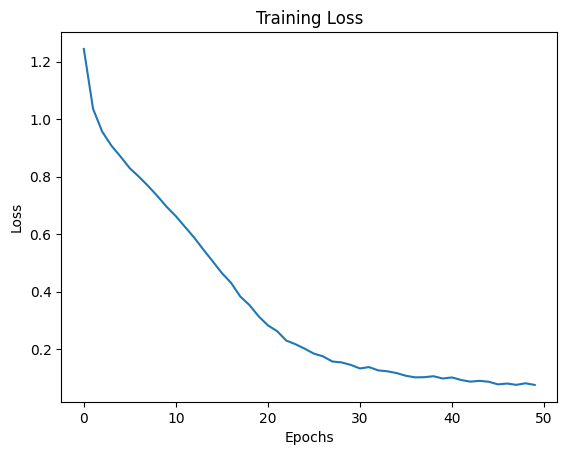

In [4]:
model = models.resnet50(weights="IMAGENET1K_V2")
model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)  # already 3-ch
num_ftrs = model.fc.in_features
model.fc  = nn.Linear(num_ftrs, 7) 

device   = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model    = model.to(device)
criterion= nn.CrossEntropyLoss()
optimizer= optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

writer = tensorboard.SummaryWriter(log_dir="runs/fer_resnet50") 
epochs = 50
losses = []

for epoch in range(epochs):
    # Training...
    model.train()
    running_loss = 0.0
    train_bar = tqdm(total=len(train_idxs), desc=f"Epoch {epoch:02d} [Train]", unit="img", dynamic_ncols=True)

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        train_bar.update(x.size(0))
        train_bar.set_postfix(loss=loss.item())

    train_bar.close()

    # Validation...
    model.eval()
    correct = total = 0
    val_bar = tqdm(total=len(val_idxs), desc=f"Epoch {epoch:02d} [Valid]", unit="img", dynamic_ncols=True)

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x).argmax(1)
            correct += (pred == y).sum().item()
            total   += y.size(0)
            val_bar.update(x.size(0))

    val_bar.close()

    train_loss = running_loss / len(train_loader.dataset)
    losses.append(train_loss)
    val_acc    = 100 * correct / total

    # <<<<<<<<<<<< Add TensorBoard logs here
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Accuracy/val', val_acc, epoch)

    print(f"Epoch {epoch:02d}: train loss {train_loss:.4f}  val acc {val_acc:.2f}%")

# after all epochs
writer.close()

plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


# Test on our trained model

Here, we proposed two tests:

1. Accuracy test: we iterate through the test dataset and see how many correct expressions we have obtained 
2. Precall, F1, ... test: Simple accuracy cannot measure the likelihood of misclassification, here we will create a heatmap to show which facial expression is easy to recognize and which is hard to tell. In addition, we will report scores of precision, recall, and F1

In [ ]:
# save the model, uncomment it if you do the training 
# model_path = f"models/fer_resnet50_epoch{epochs}.pth"
# torch.save(model.state_dict(), model_path)

# load the model
epochs=15
model_path = f"models/fer_resnet50_epoch{epochs}.pth"
model = models.resnet50(weights="IMAGENET1K_V2")
model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)  # already 3-ch
num_ftrs = model.fc.in_features
model.fc  = nn.Linear(num_ftrs, 7) 
model.load_state_dict(torch.load(model_path))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
device   = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model.to(device)

correct = total = 0
criterion = nn.CrossEntropyLoss()

test_loader  = DataLoader(test_ds,  batch_size=64, num_workers=4, pin_memory=True)

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total   += labels.size(0)

print(f"[PyTorch] Test accuracy: {correct/total:.4f} ({correct}/{total})")

Using cuda device
[PyTorch] Test accuracy: 0.6360 (4565/7178)


In [12]:
def compute_metrics(y_true, y_pred, num_classes=7):
    """
    Compute per-class and macro-averaged precision, recall, f1, and accuracy.
    Args:
        y_true: ground-truth labels (1D numpy array)
        y_pred: predicted labels (1D numpy array)
        num_classes: number of classes
    Returns:
        Dictionary containing all metrics
    """

    # 1. confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))

    # 2. Initialize
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1 = np.zeros(num_classes)

    # 3. Compute per-class metrics
    for i in range(num_classes):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp

        precision[i] = tp / (tp + fp + 1e-8)   # avoid division by 0
        recall[i] = tp / (tp + fn + 1e-8)
        f1[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i] + 1e-8)

    # 4. Macro-averaged
    precision_macro = np.mean(precision)
    recall_macro   = np.mean(recall)
    f1_macro       = np.mean(f1)

    # 5. Overall accuracy
    accuracy = np.trace(cm) / np.sum(cm)

    return {
        "precision_per_class": precision,
        "recall_per_class": recall,
        "f1_per_class": f1,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro,
        "accuracy": accuracy
    }

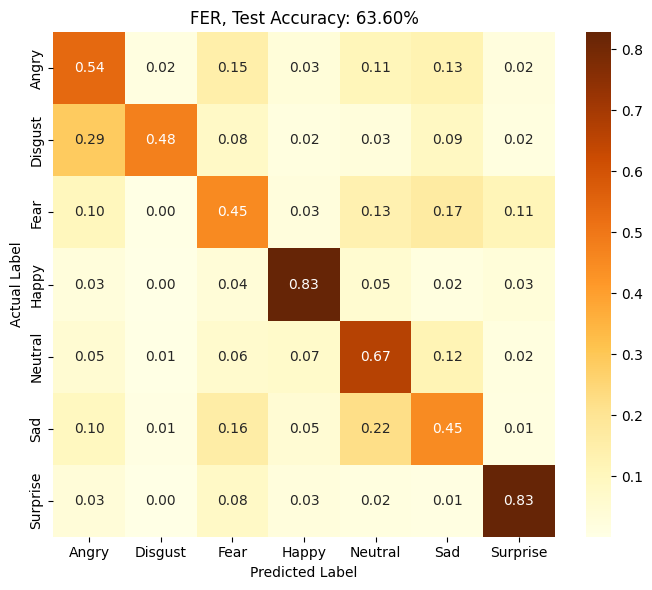

In [24]:
# Assuming you already have a trained model and test_loader
device = "cuda" if torch.cuda.is_available() else "cpu"

# 1. Predict all test images
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        preds = outputs.argmax(dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(y.cpu().numpy())

# 2. Flatten lists
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# 3. Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 4. Define class names (match the dataset folder order!)
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# 5. Plot the heatmap
plt.figure(figsize=(7,6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='YlOrBr', 
            xticklabels=class_names, yticklabels=class_names, cbar=True)

plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title(f'FER, Test Accuracy: {100*np.trace(cm)/np.sum(cm):.2f}%')
plt.tight_layout()
plt.show()


In [25]:
# after collecting all_preds and all_labels

metrics = compute_metrics(all_labels, all_preds, num_classes=7)

print(f"Overall Accuracy: {metrics['accuracy']*100:.2f}%")
print(f"Macro Precision: {metrics['precision_macro']*100:.2f}%")
print(f"Macro Recall:    {metrics['recall_macro']*100:.2f}%")
print(f"Macro F1:        {metrics['f1_macro']*100:.2f}%")

# Per class print (optional)
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

for i, classname in enumerate(class_names):
    print(f"{classname:10s}: Precision={metrics['precision_per_class'][i]*100:.2f}%, "
          f"Recall={metrics['recall_per_class'][i]*100:.2f}%, "
          f"F1={metrics['f1_per_class'][i]*100:.2f}%")


Overall Accuracy: 63.60%
Macro Precision: 60.97%
Macro Recall:    60.51%
Macro F1:        60.55%
Angry     : Precision=56.44%, Recall=53.97%, F1=55.18%
Disgust   : Precision=55.79%, Recall=47.75%, F1=51.46%
Fear      : Precision=44.89%, Recall=45.02%, F1=44.95%
Happy     : Precision=86.49%, Recall=82.64%, F1=84.52%
Neutral   : Precision=56.32%, Recall=66.50%, F1=60.99%
Sad       : Precision=52.83%, Recall=44.91%, F1=48.55%
Surprise  : Precision=74.06%, Recall=82.79%, F1=78.18%


# Test on the default model

The default model is based on the tutorial from FER Kaggle competition

The tensorflow structure is too old so that I rewritten it in the tensorflow 2.x and keras 3.x version. The model structure can be found at model.py file

The test pipeline is the same as the previous one

In [6]:
face_exp_model = build_cnn_model()
face_exp_model.load_weights('models/facial_expression_model_weights.h5')

c:\Users\yh200\PycharmProjects\CSE559\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
face_exp_model.compile(optimizer="adam",
                    loss="categorical_crossentropy",
                    metrics=["accuracy"])

test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    directory=os.path.join("dataset", "fer2013", "test"),
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=64,
    class_mode="categorical",
    shuffle=False
)

# 1.3 Evaluate
loss, acc = face_exp_model.evaluate(test_generator, verbose=1)
print(f"[Keras]  Test loss: {loss:.4f},  Test accuracy: {acc:.4f}")

Found 7178 images belonging to 7 classes.


c:\Users\yh200\PycharmProjects\CSE559\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 56s 495ms/step - accuracy: 0.4589 - loss: 3.4889
[Keras]  Test loss: 6.7201,  Test accuracy: 0.3495


113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step


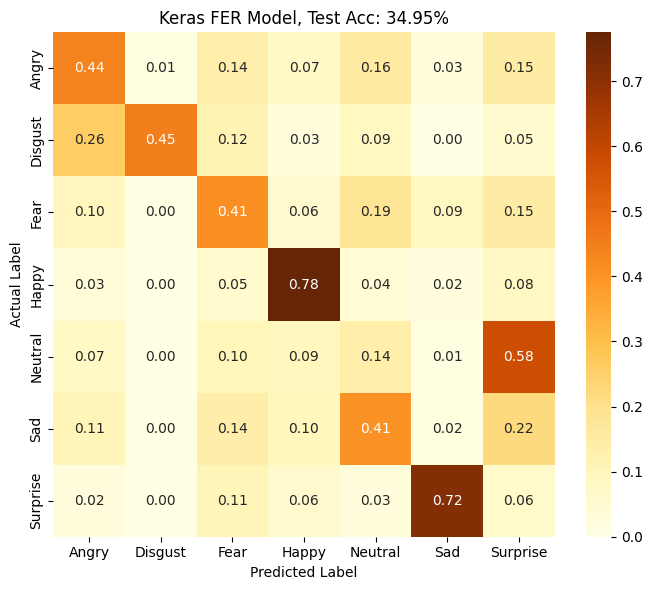

In [11]:
y_pred_probs = face_exp_model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = test_generator.classes 

cm = confusion_matrix(y_true_classes, y_pred_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

plt.figure(figsize=(7,6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='YlOrBr',
            xticklabels=class_names, yticklabels=class_names, cbar=True)

test_accuracy = 100 * np.trace(cm) / np.sum(cm)

plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title(f'Keras FER Model, Test Acc: {test_accuracy:.2f}%')
plt.tight_layout()
plt.show()

In [13]:
metrics = compute_metrics(y_true_classes, y_pred_classes, num_classes=7)

# Print overall performance
print(f"Overall Accuracy: {metrics['accuracy']*100:.2f}%")
print(f"Macro Precision: {metrics['precision_macro']*100:.2f}%")
print(f"Macro Recall:    {metrics['recall_macro']*100:.2f}%")
print(f"Macro F1:        {metrics['f1_macro']*100:.2f}%")

# Print per-class performance
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

for i, name in enumerate(class_names):
    print(f"{name:10s}: Precision={metrics['precision_per_class'][i]*100:.2f}%, "
          f"Recall={metrics['recall_per_class'][i]*100:.2f}%, "
          f"F1={metrics['f1_per_class'][i]*100:.2f}%")

Overall Accuracy: 34.95%
Macro Precision: 35.60%
Macro Recall:    32.76%
Macro F1:        33.89%
Angry     : Precision=49.65%, Recall=43.95%, F1=46.62%
Disgust   : Precision=61.73%, Recall=45.05%, F1=52.08%
Fear      : Precision=39.94%, Recall=41.11%, F1=40.52%
Happy     : Precision=76.64%, Recall=77.51%, F1=77.07%
Neutral   : Precision=15.00%, Recall=13.63%, F1=14.28%
Sad       : Precision=2.68%, Recall=1.68%, F1=2.07%
Surprise  : Precision=3.54%, Recall=6.38%, F1=4.56%
